# Introduction
Determin Porygon DT of Sampled Users to Each Restaurant


# Data collection
We get the data from big query.

In [ ]:
%%capture
# install packages
!pip install folium
!pip install geopandas

In [ ]:
# load packages
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import TimestampedGeoJson
from folium import plugins
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
import geopandas
from shapely import wkt
%matplotlib inline
#from google.colab import drive # to allow colab save file in my drive
#drive.mount('drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is not loaded.


## 1. Create temp tables

First you need to define in which country, which city and which vehicle profile you want it to run. 

Second, you run the query to create table

Third, you request the table data as a data frame.

In [ ]:
# define some variables
project_id = "fulfillment-dwh-production"
country_code_tbd = "cl" 
city_id_tbd = "210"
vehicle_profile_tbd = "bicycle_v2"
geohash_digit = "7"

# define project id
client = bigquery.Client(project = project_id)

print("This script will return price points result in a table for {a} as vehicle profile with {b}-digit geohash in City {c} of Country {d}".format(a=vehicle_profile_tbd, b=geohash_digit, c=city_id_tbd, d=country_code_tbd))

This script will return price points result in a table for bicycle_v2 as vehicle profile with 7-digit geohash in City 210 of Country cl


In [ ]:
#@title Bigquery script to create temp tables { vertical-output: true, display-mode: "both" }
# Create temp tables 
query = """
-- zone_temp to get basic zone table information
drop table if exists `temp.zone_temp_""" + country_code_tbd + """`;
CREATE TABLE `temp.zone_temp_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		c.id as city_id,
		c.name as city_name,
		z.id as zone_id,
		z.name as zone_name,
		st_astext(z.shape) as zone_shape,
		z.zone_shape_updated_at as zone_update,
	from `fulfillment-dwh-production.cl.countries`
	left join unnest(cities) c
	left join unnest(c.zones) z
	where country_code = \"""" + country_code_tbd + """\" 
  and c.id = """ + city_id_tbd + """
  group by 1,2,3,4,5,6,7);

-- zone table to get the most up to date zone shape
drop table if exists `temp.zone_""" + country_code_tbd + """`;
CREATE TABLE `temp.zone_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select a.*
	from temp.zone_temp_""" + country_code_tbd + """ a
	join
		(select
			country_code,
			city_id,
			zone_id,
			zone_name,
			zone_shape,
			max(zone_update) as zone_update
		from temp.zone_temp_""" + country_code_tbd + """
		group by 1,2,3,4,5) b
	on a.country_code = b.country_code and a.city_id = b.city_id and a.zone_id = b.zone_id and a.zone_update = b.zone_update);

-- res_location table to get restaurant location info
drop table if exists `temp.res_location_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_location_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		city_id,
		vendor_code,
		st_x(location) as res_long,
		st_y(location) as res_lat,
	from `fulfillment-dwh-production.cl.vendors`
	left join unnest(delivery_areas) d
	where country_code = \"""" + country_code_tbd + """\" 
	and city_id = """ + city_id_tbd + """
	group by 1,2,3,4,5);

-- res_zone to map restaurant with zone_id by looking at restaurant location and up-to-date zone shape
drop table if exists `temp.res_zone_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_zone_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		z.country_code,
		z.city_id,
		vendor_code,
		z.zone_id  as res_zone_id
	from temp.zone_""" + country_code_tbd + """ z
	inner join temp.res_location_""" + country_code_tbd + """ r
	on z.country_code = r.country_code
	and z.city_id = r.city_id
	and st_within(st_geogpoint(r.res_long,r.res_lat), st_geogfromtext(z.zone_shape)));

-- each restaurant should has its zone_id, restaurant could have more than one zone_id
drop table if exists `temp.res_zoneid_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_zoneid_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		city_id,
		vendor_code,
		res_zone_id
	from temp.res_zone_""" + country_code_tbd + """
	where true
	and res_zone_id is not null
	group by 1,2,3,4);

--add porygon vehicle_profile by restaurant .. asdas

-- porygon_temp table to have up to date porygon area
drop table if exists `temp.porygon_temp_""" + country_code_tbd + """`;
CREATE TABLE `temp.porygon_temp_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		a.restaurant_id,
		a.time,
		a.country_code,
		a.shape_wkt
	from `fulfillment-dwh-production.dl.porygon_drive_time_polygons` a
	inner join
		(select
			restaurant_id,
			time,
			country_code,
			shape_wkt,
			vehicle_profile,
			max(updated_at) as updated_at
		from `fulfillment-dwh-production.dl.porygon_drive_time_polygons`
		where vehicle_profile = \"""" + vehicle_profile_tbd + """\" 
    and country_code = \"""" + country_code_tbd + """\" 
		group by 1,2,3,4,5) b
	on a.restaurant_id = b.restaurant_id and a.country_code = b.country_code and a.updated_at = b.updated_at
	group by 1,2,3,4);

-- make the timeframe dynamic (last x days?)

-- porygon table to have zone_id for each restaurant and up-to-date shape for different driving times with assigned vehicle profile
drop table if exists `temp.porygon_""" + country_code_tbd + """`;
CREATE TABLE `temp.porygon_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		p.*,
		v.city_id,
		r.res_zone_id
	from temp.porygon_temp_""" + country_code_tbd + """ p
	inner join
		(select
			vendor.vendor_code as vendor_code,
			city_id,
			country_code
		from `fulfillment-dwh-production.cl.orders`
		where cast(order_placed_at as date) >= "2020-01-01"
			and country_code = \"""" + country_code_tbd + """\" 
			and city_id = """ + city_id_tbd + """
	group by 1,2,3) v
	on p.restaurant_id = v.vendor_code and lower(p.country_code) = lower(v.country_code)
	inner join temp.res_zoneid_""" + country_code_tbd + """ r
	on p.restaurant_id = r.vendor_code and lower(p.country_code) = lower(r.country_code));


-- get all user location
drop table if exists `temp.user_location_""" + country_code_tbd + """`;
CREATE TABLE `temp.user_location_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		ST_X(customer.location) as user_lon, --> check if we can change this to dropoff location
		ST_Y(customer.location) user_lat, --> check if we can change this to dropoff location
		zone_id
	from `fulfillment-dwh-production.cl.orders`
	where city_id = """ + city_id_tbd + """
		and country_code = \"""" + country_code_tbd + """\" 
		and zone_id is not null
		and cast(order_placed_at as date) >= "2020-01-01"
	group by 1,2,3);

-- sample certain user amount
drop table if exists `temp.user_geohash_""" + country_code_tbd + """`;
CREATE TABLE `temp.user_geohash_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		st_geohash(st_geogpoint(user_lon, user_lat),""" + geohash_digit + """) as geohash, --> 6: Area width 1.2km x 609.4m height
		zone_id as user_zone_id,
		count(*) as weight
	from temp.user_location_""" + country_code_tbd + """
	group by 1,2);

drop table if exists `temp.first_match_""" + country_code_tbd + """`;
CREATE TABLE `temp.first_match_""" + country_code_tbd + """`
OPTIONS(
	  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
	) as (
	select
		u.*,
		p.*
	from temp.user_geohash_""" + country_code_tbd + """ u
	cross join temp.porygon_""" + country_code_tbd + """ p
	where u.user_zone_id = p.res_zone_id and st_within(st_geogpointfromgeohash(u.geohash), safe.ST_GEOGFROMTEXT(p.shape_wkt)));

drop table if exists `temp.results_""" + country_code_tbd + """`;
CREATE TABLE `temp.results_""" + country_code_tbd + """`
	OPTIONS(
	  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
	) as (
select
	user_zone_id,
	geohash,
	st_astext(st_geogpointfromgeohash(geohash)) as geohash_center,
	restaurant_id,
	avg(weight) as weight,
	min(time) as porygon_dt
from temp.first_match_""" + country_code_tbd + """
group by 1,2,3,4)
"""

query_job = client.query(query)  # Make an API request.


In [ ]:
query2 = """
SELECT
    a.*
    , st_x(st_geogfromtext(geohash_center)) as long
    , st_y(st_geogfromtext(geohash_center)) as lat
    , b.zone_name
  FROM
    `temp.results_""" + country_code_tbd + """` a
  left join `temp.zone_""" + country_code_tbd + """` b
  on a.user_zone_id = b.zone_id
    """

df = client.query(query2).to_dataframe()
df.head()

,user_zone_id,geohash,geohash_center,restaurant_id,weight,porygon_dt,long,lat,zone_name
0,64,62s5fze,POINT(-72.9993438720703 -41.4864349365234),65125,7.0,1,-72.999344,-41.486435,Puerto Montt
1,64,62s5fzs,POINT(-72.9979705810547 -41.4864349365234),65125,18.0,1,-72.997971,-41.486435,Puerto Montt
2,64,62s5gxt,POINT(-72.9636383056641 -41.4864349365234),140977,4.0,1,-72.963638,-41.486435,Puerto Montt
3,64,62s5gxv,POINT(-72.9636383056641 -41.4850616455078),140977,12.0,1,-72.963638,-41.485062,Puerto Montt
4,64,62s5gxv,POINT(-72.9636383056641 -41.4850616455078),104975,12.0,1,-72.963638,-41.485062,Puerto Montt


In [ ]:
# if you want to have 
zone_id = df.user_zone_id.unique()
zone_id = zone_id.tolist()
zone_id

[64, 65]

**IMPORTANT:** about choosing zones!

If you want to choose all zones, then you need to do nothing
If you want to choose one zone or more thatn one zones, then remove the "#" and put the zone_ids in the branket and run the script 

In [ ]:
zone_id = [64]
zone_id_tbd = "64"
df = df[df["user_zone_id"].isin(zone_id)]

In [ ]:
pivot=df.pivot_table("restaurant_id", index=['geohash_center',"geohash","weight"], columns='porygon_dt', aggfunc='count')
totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot

,,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
geohash_center,geohash,weight,,,,,,,,,,,,,,,,,,,,
POINT(-72.8551483154297 -41.4850616455078),62s5ypu,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
POINT(-72.8661346435547 -41.4864349365234),62s5vzs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,18.0,15.0,31.0
POINT(-72.8881072998047 -41.4823150634766),62shj2k,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,19.0,17.0,10.0,18.0,23.0,26.0,18.0,28.0
POINT(-72.8894805908203 -41.4809417724609),62shj2e,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,10.0,18.0,12.0,6.0,13.0,27.0,25.0,34.0,9.0,23.0
POINT(-72.8894805908203 -41.4823150634766),62shj27,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,6.0,11.0,14.0,12.0,16.0,26.0,23.0,31.0,15.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POINT(-73.0062103271484 -41.4864349365234),62s5fxw,13.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,6.0,2.0,2.0,2.0,4.0,2.0,6.0,4.0,10.0,9.0,24.0,26.0,27.0
POINT(-73.0062103271484 -41.4878082275391),62s5fxq,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,3.0,4.0,6.0,8.0,8.0,9.0,14.0
POINT(-73.0062103271484 -41.4905548095703),62s5fwy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,3.0,2.0,7.0,2.0,5.0,8.0


In [ ]:
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

,,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
geohash_center,geohash,weight,,,,,,,,,,,,,,,,,,,,
POINT(-72.8551483154297 -41.4850616455078),62s5ypu,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,5.0
POINT(-72.8661346435547 -41.4864349365234),62s5vzs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5.0,6.0,24.0,39.0,70.0
POINT(-72.8881072998047 -41.4823150634766),62shj2k,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,6.0,25.0,42.0,52.0,70.0,93.0,119.0,137.0,165.0
POINT(-72.8894805908203 -41.4809417724609),62shj2e,4.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,14.0,32.0,44.0,50.0,63.0,90.0,115.0,149.0,158.0,181.0
POINT(-72.8894805908203 -41.4823150634766),62shj27,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,9.0,20.0,34.0,46.0,62.0,88.0,111.0,142.0,157.0,178.0


## Insight 
### Insight 1: Share of Customers seeing free delivery restaurants depending on the first tier size

In [ ]:
weight = pivot_cumsum
weight = weight.reset_index()

numOfRestaurants = [1, 10, 20, 30, 40, 50, 75, 100, 125, 175, 225]

# add a changable porygon driving time 
drivingTimesinMin = list(pivot_cumsum)
resArray = []
for indexNumOfRestaurants in numOfRestaurants:
    sumByDrivingTimes = []
    for indexDrivingTimesInMin in drivingTimesinMin:
        sumByDrivingTimes.append(weight.loc[weight[indexDrivingTimesInMin] >= indexNumOfRestaurants, "weight"].sum())
        
    sumByDrivingTimes.insert(0,indexNumOfRestaurants)
    resArray.append(sumByDrivingTimes)

resArray

colNames = np.append("Number of Restaurants", drivingTimesinMin)

df2 = pd.DataFrame(resArray,
                   columns = colNames)
df2=df2.set_index('Number of Restaurants')
col_list = list(df2)
totalnum = weight["weight"].sum()
df2=df2[col_list].div(totalnum)
#df2=df2.reset_index()
df2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Number of Restaurants,,,,,,,,,,,,,,,,,,,,
1,0.299827,0.763168,0.919787,0.965055,0.984558,0.996615,0.997081,0.998392,0.998731,0.999112,0.999746,0.999831,0.999915,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
10,0.021449,0.067987,0.276600,0.664297,0.827982,0.891611,0.935313,0.961628,0.969539,0.981385,0.991412,0.998265,0.998985,0.999196,0.999831,0.999831,0.999873,0.999915,0.999915,0.999958
20,0.012354,0.032153,0.084909,0.273681,0.495283,0.719127,0.828320,0.894445,0.935271,0.958159,0.970512,0.989423,0.996150,0.998265,0.998858,0.999323,0.999831,0.999873,0.999915,0.999915
30,0.000000,0.019249,0.058002,0.142108,0.279858,0.499640,0.640014,0.776452,0.857004,0.912256,0.938359,0.961120,0.976351,0.989381,0.997589,0.997885,0.999196,0.999704,0.999746,0.999915
40,0.000000,0.005034,0.039768,0.122731,0.185176,0.404662,0.528747,0.669120,0.770022,0.858485,0.907645,0.937344,0.956593,0.977451,0.989677,0.997589,0.997842,0.999154,0.999238,0.999662
50,0.000000,0.000000,0.029149,0.099378,0.158819,0.302534,0.433473,0.581673,0.683039,0.800398,0.863815,0.920421,0.939967,0.961543,0.977281,0.988408,0.997462,0.998012,0.998858,0.999281
75,0.000000,0.000000,0.004992,0.040487,0.108601,0.185726,0.301180,0.429073,0.547870,0.655286,0.745611,0.854973,0.897576,0.934044,0.951051,0.971105,0.981681,0.996658,0.998181,0.998604
100,0.000000,0.000000,0.000000,0.000000,0.011127,0.123197,0.210306,0.348521,0.439480,0.563523,0.661294,0.767229,0.853535,0.906714,0.933240,0.954732,0.968989,0.985108,0.996108,0.997208
125,0.000000,0.000000,0.000000,0.000000,0.000000,0.004188,0.109912,0.250624,0.361213,0.481237,0.579896,0.702543,0.788086,0.871092,0.909168,0.938952,0.952151,0.974405,0.985277,0.996362


Text(249.0, 0.5, 'Number of Restaurants')

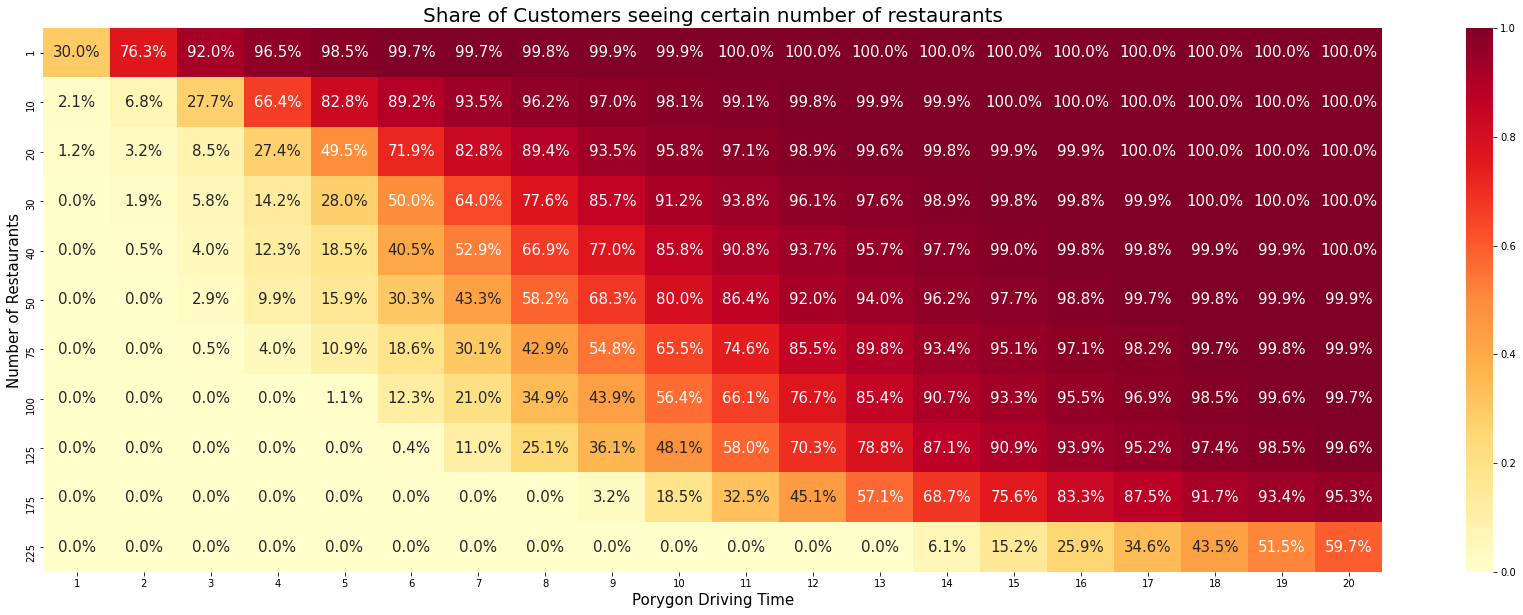

In [ ]:
plt.subplots(figsize=(30,10))
sns.heatmap(df2, fmt=".1%", annot=True, cmap='YlOrRd', annot_kws={"fontsize":15})
#sns.heatmap(df2, fmt=".1%", annot=True, cmap='viridis')
plt.title('Share of Customers seeing certain number of restaurants', fontsize = 20)

plt.xlabel('Porygon Driving Time', fontsize = 15)
plt.ylabel('Number of Restaurants', fontsize = 15)

### Insight 2: The marginal effect of expanding porygon driving time areas


In [ ]:
pivot_cumsum.head()
pory_margin = pivot_cumsum.mean()
pory_margin = pd.DataFrame(pory_margin, columns = ["restaurants"])

row = list(pory_margin.index.values)
row = row[1:]
count_a_vals = pory_margin['restaurants'].values
delta = (count_a_vals[1:] - count_a_vals[:-1])/count_a_vals[:-1]

delta = pd.DataFrame(delta, columns = ["Marginal increase of Restaurant Number"])
delta["Increase to Porygon DT"] = row
delta

,Marginal increase of Restaurant Number,Increase to Porygon DT
0,4.522293,2
1,1.720877,3
2,1.261763,4
3,0.560772,5
4,0.581417,6
5,0.350627,7
6,0.365764,8
7,0.238283,9
8,0.246277,10
9,0.169482,11


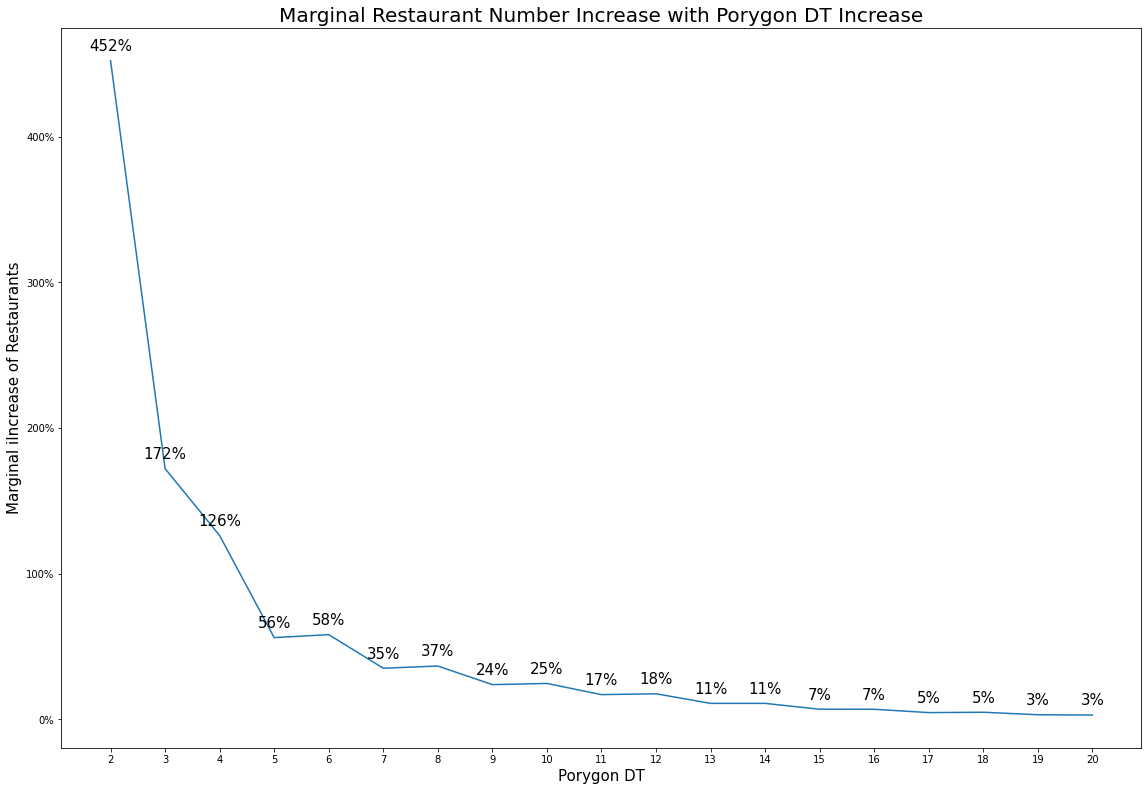

In [ ]:
#@title Marginal Restaurant Increase with Porygon DT increase
fig = plt.figure()
xs = delta["Increase to Porygon DT"]
ys = delta["Marginal increase of Restaurant Number"]
axes = fig.add_axes([0.1, 0.1, 2.5, 2.5])
axes.plot(xs, ys)
for x,y in zip(xs,ys):
    label = "{:.0f}%".format(y*100)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 15) # horizontal alignment can be left, right or center

axes.set_xlabel('Porygon DT', fontsize = 15)
axes.set_ylabel('Marginal iIncrease of Restaurants', fontsize = 15)
axes.set_title('Marginal Restaurant Number Increase with Porygon DT Increase', fontsize = 20)
axes.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
axes.set_xticks(delta['Increase to Porygon DT'])

plt.show()

## Insight 3: Map Visualisation



In [ ]:
query2 = """
SELECT
    st_x(st_geogfromtext(geohash_center)) as long
    , st_y(st_geogfromtext(geohash_center)) as lat
    , geohash
    , user_zone_id
    , zone_name
    , count(restaurant_id) as number_of_resutaurant
    , avg(weight) as weight
  FROM
    `temp.results_""" + country_code_tbd + """` a
    left join `temp.zone_""" + country_code_tbd + """` b
    on a.user_zone_id = b.zone_id
    
    group by 1,2,3,4, 5
    """

df_x = client.query(query2).to_dataframe()

query3 = """
SELECT
    distinct
    zone_id
    , zone_name
    , zone_shape
  FROM
   `temp.zone_""" + country_code_tbd + """` 
   
    """

zone = client.query(query3).to_dataframe()

In [ ]:
zone_geo = zone
zone_geo["zone_shape"] = zone_geo["zone_shape"].apply(wkt.loads)

In [ ]:
# map
map = folium.Map(location=[df_x["lat"].mean(), df_x["long"].mean()], width = "100%", height= "100%",zoom_start=14)

# add tiles to map
folium.raster_layers.TileLayer('Open Street Map').add_to(map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map)

style = {'fillColor': 'none', 'lineColor': 'grey'}

# add layer "zone shape" to map
zone_geo.apply(lambda row:folium.GeoJson(row["zone_shape"], name="zone_name",style_function=lambda x: style).add_to(map), axis=1)
#folium.GeoJson(zone_geo["zone_shape"], name="Zone Border").add_to(map)

# add layer control to show different maps
folium.LayerControl().add_to(map)

#draw = plugins.Draw(export=True)
#draw.add_to(map)

# add marker
df_x.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=row["weight"]/5,
                                              popup="Number of users: {},    Number of Restaurants to be seen: {},     Zone Name: {}".format(row["weight"], row["number_of_resutaurant"], row["zone_name"]),
                                              color='',
                                              fill_color="red")
                                              .add_to(map), axis=1)

# display map
map

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pivot_cumsum.head()
pory_margin = pivot_cumsum.mean()
pory_margin = pd.DataFrame(pory_margin, columns = ["restaurants"])
pory_margin

,restaurants
porygon_dt,
1,0.397217
2,2.193548
3,5.968374
4,13.499051
5,21.068944
6,33.318786
7,45.001265
8,61.461101
9,76.106262
